# Twitter Sentiment Analysis

Name: Faris Chaudhry

Country: United Kingdom

Email: faris.chaudhry@outlook.com

## Imports

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import re
import scipy.stats as stats
import gensim
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb



## Helper Functions

In [185]:
# Average word length (rounded to 3 dp)
def avg_word_length(sentence):
    words = sentence.split()
    return round((sum(len(word) for word in words)/float(len(words))), 3)

## Dataframes

In [186]:
traindata_filepath = "train_tweets.csv"
testdata_filepath = "test_tweets.csv"

In [187]:
train_df = pd.read_csv(traindata_filepath, index_col=0)
test_df = pd.read_csv(testdata_filepath, index_col=0)
train_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


In [188]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


In [189]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17197 entries, 31963 to 49159
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 268.7+ KB


## Validation

In [190]:
# Standardise column names
train_df.columns = list(map(lambda x: x.strip('_').lower(), list(train_df.columns)))
test_df.columns = list(map(lambda x: x.strip('_').lower(), list(test_df.columns)))

# Remove duplicate tweets
train_df.drop_duplicates(subset=['tweet'], keep='last', inplace=True)
test_df.drop_duplicates(subset=['tweet'], keep='last', inplace=True)

# Remove null tweets
train_df.dropna(subset=['tweet'], inplace=True)
test_df.dropna(subset=['tweet'], inplace=True)

# Remove unlabelled training data
train_df.dropna(subset=['label'], inplace=True)

# # Reindex to remove null or duplicate indexes
# train_df = train_df.reindex(np.arange(train_df.index.min(), train_df.index.max() + 1))
# test_df = test_df.reindex(np.arange(test_df.index.min(), test_df.index.max() + 1))

train_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


### Upsampling

In [191]:
train_majority = train_df[train_df.label==0]
train_minority = train_df[train_df.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_df = pd.concat([train_minority_upsampled, train_majority])
train_df['label'].value_counts()

label
1    27517
0    27517
Name: count, dtype: int64

## Simple Feature Extraction

In [192]:
# Character and word count
# train_df['char_count'] = train_df['tweet'].str.len() # Character count is redundant with word and average characters in word. 
train_df['word_count'] = train_df['tweet'].apply(lambda x: len(str(x).split(" ")))

# Average word length
train_df['avg_word'] = train_df['tweet'].apply(lambda x: avg_word_length(x))

# Hashtags
train_df['hashtags'] = train_df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Exclamation marks
train_df['exclamation_marks'] = train_df['tweet'].str.count('!')

# Question Marks
train_df['question_marks'] = train_df['tweet'].str.count('\?')

# Uppercase words
train_df['upper'] = train_df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

train_df

,label,tweet,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
id,,,,,,,,
24643,1,if you're mad about @user and their interracia...,17,6.438,3,0,0,0
22452,1,@user well there's a surprise.... wonder how m...,14,5.000,0,0,0,0
22720,1,iâve had my id checked by the police zero ti...,25,4.042,0,0,0,0
21965,1,i hope the guy won't say how come only trump ...,24,4.500,1,1,0,0
31961,1,"@user #sikh #temple vandalised in in #calgary,...",13,5.500,4,0,0,0
...,...,...,...,...,...,...,...,...
31957,0,off fishing tomorrow @user carnt wait first ti...,13,4.455,0,0,0,0
31958,0,ate @user isz that youuu?ðððððð...,6,12.600,0,0,1,0
31959,0,to see nina turner on the airwaves trying to...,25,4.652,2,0,0,0


In [193]:
train_df.corr(numeric_only=True)

,label,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
label,1.000000,0.014321,-0.036854,-0.073075,-0.119554,0.082487,0.012108
word_count,0.014321,1.000000,-0.342453,0.027704,-0.002359,0.076581,0.030690
avg_word,-0.036854,-0.342453,1.000000,0.375081,0.032546,-0.063528,-0.007004
hashtags,-0.073075,0.027704,0.375081,1.000000,-0.004504,-0.037695,0.017493
exclamation_marks,-0.119554,-0.002359,0.032546,-0.004504,1.000000,-0.026852,-0.007022
question_marks,0.082487,0.076581,-0.063528,-0.037695,-0.026852,1.000000,0.077622
upper,0.012108,0.030690,-0.007004,0.017493,-0.007022,0.077622,1.000000


No high correlation between basic features so no need to remove any. 

## Data Cleaning

### Standardisation

In [194]:
# Make all words lowercase (no long case-sensitive)
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuation
train_df['tweet'] = train_df['tweet'].str.replace('[^\w\s]','')

# Removal of stopwords
stop = stopwords.words('english')
train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Remove noise from common and rare words in tweets

In [195]:
pd.Series(' '.join(train_df['tweet']).split()).value_counts()[:5]


@user    38466
&amp;     4117
â¦       2381
-         2044
like      2020
Name: count, dtype: int64

In [196]:
# # Common word removal (top 5 words)
# common = list(pd.Series(' '.join(train_df['tweet']).split()).value_counts()[:5].index)
# train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in common))

# # Rare word removal (all words with count of 1)
# rare = pd.Series(' '.join(train_df['tweet']).split()).value_counts().to_frame()
# rare = list(rare.loc[(rare['count'] <= 1)].index)
# train_df['tweet'] = train_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

### Spelling Correction

This approach doesn't work very well without changing abberviations of words to their normal form. 


In [197]:
# train_df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Suffix and Prefix Removal

Removes suffixes and prefixes from words.

In [198]:
# ps = PorterStemmer()
# train_df['tweet'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

# train_df

### Lemmatization

Makes word into root word. 

In [199]:
# train['tweet'] = train['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# train_df

## Tokenization

In [200]:
# Tokenizes each tweet
for index, row in train_df.iterrows():
    row['tweet'] = TextBlob(row['tweet']).words

train_df

,label,tweet,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper
id,,,,,,,,
24643,1,"mad @user interracial couple tweet, go fuck yo...",17,6.438,3,0,0,0
22452,1,@user well there's surprise.... wonder much bi...,14,5.000,0,0,0,0
22720,1,iâve id checked police zero times 8 months. ...,25,4.042,0,0,0,0
21965,1,hope guy say come trump gets speak mind ð­.....,24,4.500,1,1,0,0
31961,1,"@user #sikh #temple vandalised #calgary, #wso ...",13,5.500,4,0,0,0
...,...,...,...,...,...,...,...,...
31957,0,fishing tomorrow @user carnt wait first time 2...,13,4.455,0,0,0,0
31958,0,ate @user isz youuu?ððððððð...,6,12.600,0,0,1,0
31959,0,see nina turner airwaves trying wrap mantle ge...,25,4.652,2,0,0,0


## EDA

### Vectorisation (Glove Embeddings)

GloVe (Global Vectors for Word Representation) files can be found pretrained online. This will only work if all the words in the tweet are present in the vectorizer (i.e., phrase needs to be spell checked first). Otherwise a word not present error will be raised.

In [201]:
filename = 'glove.word2vec'
vectorizer = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=False)

In [202]:
# phrase = train_df['tweet'].iloc[2]

# for word in phrase.split():
#     print(word)
#     word_arr += vectorizer[word]

# word_arr /= len(phrase.split())

# train_df['vectorized_tweet'] = word_arr

# word_arr

### Term Frequency 

Measurement of how frequently a term occurs within a document. A word with occurences in multiple tweets should have more significance.

In [203]:
# nfreq = len(train_df)
nfreq = 1000 #testing value

termfreq_df = (train_df['tweet'][1:nfreq]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
termfreq_df.rename(columns={0: 'tf'}, inplace=True)
# termfreq_df['tf'] = round(termfreq_df['tf'])

termfreq_df

,index,tf
0,@user,788.0
1,well,6.0
2,there's,3.0
3,surprise....,2.0
4,wonder,3.0
...,...,...
4184,this...,1.0
4185,become,1.0
4186,attorney,1.0
4187,general.,1.0


## Word Cloud (After Upsampling)

Text(0.5, 1.0, 'Hate Comments')

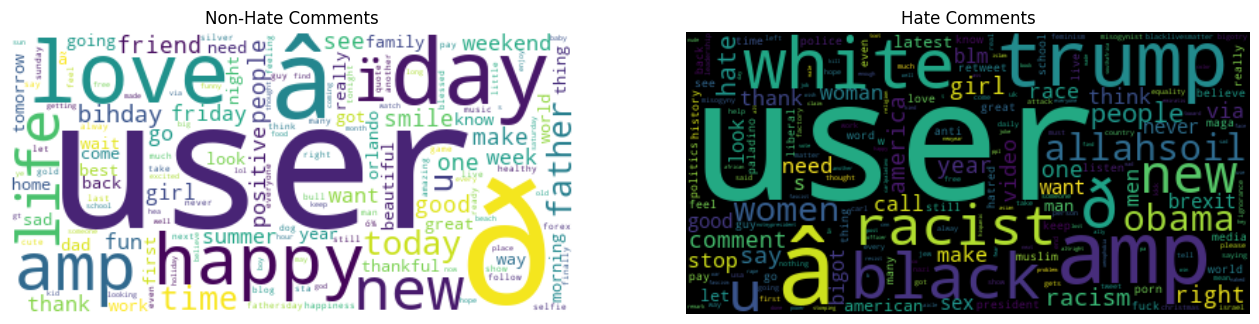

In [204]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_df['tweet'][train_df.label == 0])
text_neg = " ".join(train_df['tweet'][train_df.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

### Inverse Document Frequency

IDF(word) = log(number of entries / number of entries contianing word). 
Word appearing too often isn't of much use because it only adds statistical noise.

In [205]:
for i,word in enumerate(termfreq_df['index']):
    try:
        termfreq_df.loc[i, 'idf'] = np.log(train_df.shape[0]/(len(train_df[train_df['tweet'].str.contains(word)])))
    except:
        termfreq_df.loc[i, 'idf'] = 0

termfreq_df

C:\Users\faris\AppData\Local\Temp\ipykernel_11940\19812346.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  termfreq_df.loc[i, 'idf'] = np.log(train_df.shape[0]/(len(train_df[train_df['tweet'].str.contains(word)])))


,index,tf,idf
0,@user,788.0,0.814188
1,well,6.0,4.518777
2,there's,3.0,6.252267
3,surprise....,2.0,5.554414
4,wonder,3.0,5.355025
...,...,...,...
4184,this...,1.0,4.556133
4185,become,1.0,5.791742
4186,attorney,1.0,6.625247
4187,general.,1.0,6.681600


### TF-IDF

TF-IDF = tf * idf. Reduces significance of commonly occuring words even if they have a high idf. However, since the words are already tokenized, tf and idf have a very high correlation, so keeping both only increases dimensionality. 

In [206]:
termfreq_df['tf_idf'] = termfreq_df['tf'] * termfreq_df['idf']

termfreq_df

,index,tf,idf,tf_idf
0,@user,788.0,0.814188,641.580185
1,well,6.0,4.518777,27.112661
2,there's,3.0,6.252267,18.756802
3,surprise....,2.0,5.554414,11.108829
4,wonder,3.0,5.355025,16.065074
...,...,...,...,...
4184,this...,1.0,4.556133,4.556133
4185,become,1.0,5.791742,5.791742
4186,attorney,1.0,6.625247,6.625247
4187,general.,1.0,6.681600,6.681600


In [207]:
termfreq_df.corr(numeric_only=True)

,tf,idf,tf_idf
tf,1.000000,-0.145571,0.801112
idf,-0.145571,1.000000,-0.152258
tf_idf,0.801112,-0.152258,1.000000


### Sentiment

In [208]:
train_df['sentiment'] = train_df['tweet'].apply(lambda x: TextBlob(x).sentiment[0])

train_df[['tweet', 'label', 'sentiment']]

,tweet,label,sentiment
id,,,
24643,"mad @user interracial couple tweet, go fuck yo...",1,-0.5125
22452,@user well there's surprise.... wonder much bi...,1,0.2000
22720,iâve id checked police zero times 8 months. ...,1,0.0000
21965,hope guy say come trump gets speak mind ð­.....,1,0.0000
31961,"@user #sikh #temple vandalised #calgary, #wso ...",1,0.0000
...,...,...,...
31957,fishing tomorrow @user carnt wait first time 2...,0,0.2500
31958,ate @user isz youuu?ððððððð...,0,0.0000
31959,see nina turner airwaves trying wrap mantle ge...,0,0.4000


In [209]:
train_df.loc[(train_df['sentiment'] < 0) & (train_df['label'] == 1), 'tweet']

id
24643    mad @user interracial couple tweet, go fuck yo...
28316    #conormcgregor runs mouth endlessly like #rond...
25515    @user #gop #cons voted #nazi #fascist #dictato...
20223    case commonwealth internet vs @user evidence p...
1769     #japan abe government mere puppet ultra righti...
                               ...                        
3400     #gop #deplorable seen many "conservative" meme...
18545    @user time #fightback evil men #donaldtrump #h...
5670                    everyday life white south african.
15769    trump ny co-chair: want obama die mad cow dise...
7195     ouuh fuck it! @user @user @user @user #bustymi...
Name: tweet, Length: 7542, dtype: object

In [210]:
train_df.corr(numeric_only=True)

,label,word_count,avg_word,hashtags,exclamation_marks,question_marks,upper,sentiment
label,1.000000,0.014321,-0.036854,-0.073075,-0.119554,0.082487,0.012108,-0.238596
word_count,0.014321,1.000000,-0.342453,0.027704,-0.002359,0.076581,0.030690,-0.026786
avg_word,-0.036854,-0.342453,1.000000,0.375081,0.032546,-0.063528,-0.007004,0.041303
hashtags,-0.073075,0.027704,0.375081,1.000000,-0.004504,-0.037695,0.017493,0.100680
exclamation_marks,-0.119554,-0.002359,0.032546,-0.004504,1.000000,-0.026852,-0.007022,0.104755
question_marks,0.082487,0.076581,-0.063528,-0.037695,-0.026852,1.000000,0.077622,-0.050171
upper,0.012108,0.030690,-0.007004,0.017493,-0.007022,0.077622,1.000000,-0.011331
sentiment,-0.238596,-0.026786,0.041303,0.100680,0.104755,-0.050171,-0.011331,1.000000


### Univariate analysis

#### Word Count

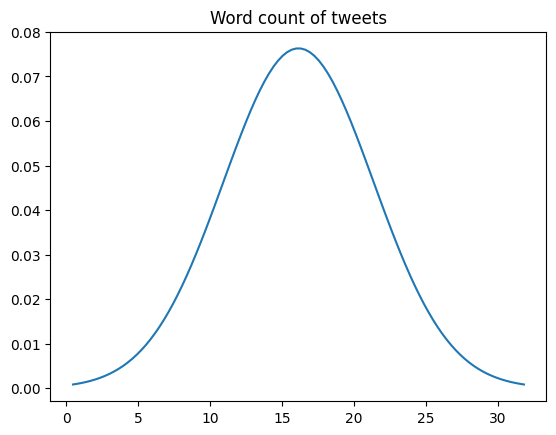

0.038463740163677144

In [211]:
mu = train_df['word_count'].mean()
sigma = train_df['word_count'].std()

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title("Word count of tweets")
plt.show()

# Skewness is quite low so normal distribution is quite accurate. 
train_df['word_count'].skew()


#### Word Length

In [212]:
train_df['avg_word'].mean()
train_df['avg_word'].std()
train_df['avg_word'].skew() # Skewness here is quite high

6.570751401676277

#### Question Marks

question_marks
0     50270
1      3868
2       614
3       166
4        99
5        10
6         6
12        1
Name: count, dtype: int64

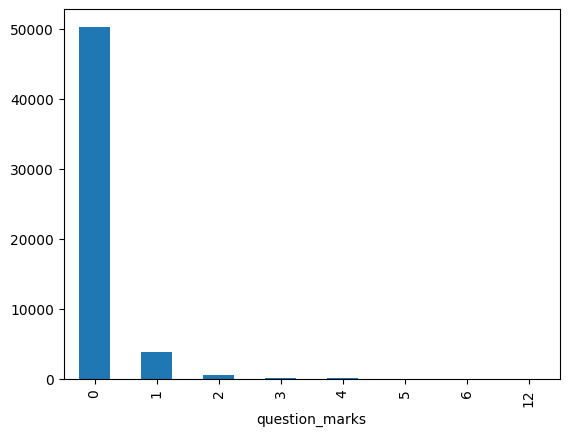

In [213]:
train_df['question_marks'].value_counts().sort_index().plot(kind="bar")
train_df['question_marks'].value_counts().sort_index()

#### Exclamation Mark

exclamation_marks
0     43792
1      7486
2      2157
3       914
4       317
5       135
6       106
7        49
8        35
9        13
10        5
11        4
12        3
13        6
14        5
15        3
16        2
19        1
58        1
Name: count, dtype: int64

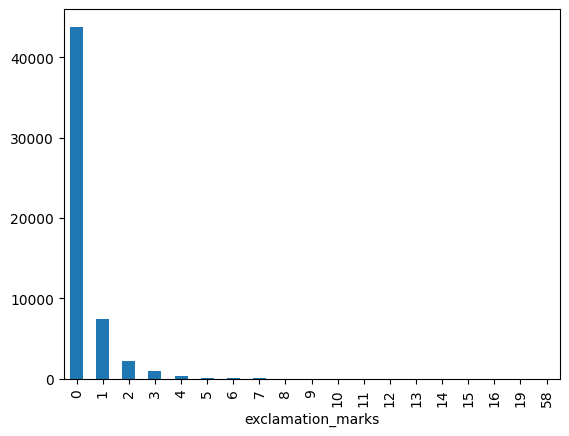

In [214]:
train_df['exclamation_marks'].value_counts().sort_index().plot(kind="bar")
train_df['exclamation_marks'].value_counts().sort_index()

## Model Creation

In [215]:
X = train_df.reset_index().drop(['label', 'id'], axis=1)
y = train_df['label']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=1)

X_train.set_index('tweet', inplace=True)
X_train = X_train.to_numpy()

X_validate.set_index('tweet', inplace=True)
X_validate = X_validate.to_numpy()

y_train.to_frame().set_index('label', inplace=True)
y_train = y_train.to_numpy()

y_validate.to_frame().set_index('label', inplace=True)
y_validate = y_validate.to_numpy()

In [216]:
def scorer(y_validate, y_pred):
    print("Number of mislabeled points out of a total %d points : %d"
    % (X_validate.shape[0], (y_validate != y_pred).sum()))

    print("Number of correctly labelled points out of a total %d points : %d"
    % (X_validate.shape[0], (y_validate == y_pred).sum()))

    print("Number of false positives out of a total %d points : %d"
    % (X_validate.shape[0], ((y_validate != y_pred) & (y_pred == 1)).sum()))

    print("Number of false negatives out of a total %d points : %d"
    % (X_validate.shape[0], ((y_validate != y_pred) & (y_pred == 0)).sum()))

    tp = ((y_validate == y_pred) & (y_pred == 1)).sum()
    fp = ((y_validate != y_pred) & (y_pred == 1)).sum()
    fn = ((y_validate != y_pred) & (y_pred == 0)).sum()
    
    prec =  tp / (tp + fp)
    recall = tp / (tp + fn)

    return prec, recall

### K-Nearest Neighbor (KNN)

In [231]:
knn = Pipeline([
    ('tfidf',  TfidfTransformer(smooth_idf=True)),
    ('nb', KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', leaf_size=30, p=1)),])


model = knn.fit(X_train, y_train)
y_predict = model.predict(X_validate)

knn_prec, knn_recall = scorer(y_validate, y_predict)
knn_f1 = f1_score(y_validate, y_predict)
knn_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', knn_f1)
print('Accuracy_Score: ', knn_acc)
print('--'*20)



Number of mislabeled points out of a total 11007 points : 550
Number of correctly labelled points out of a total 11007 points : 10457
Number of false positives out of a total 11007 points : 443
Number of false negatives out of a total 11007 points : 107
----------------------------------------
F1_Score:  0.9525289142068012
Accuracy_Score:  0.9500317979467612
----------------------------------------


ValueError: n_features must be equal to 2. Got 7 instead.

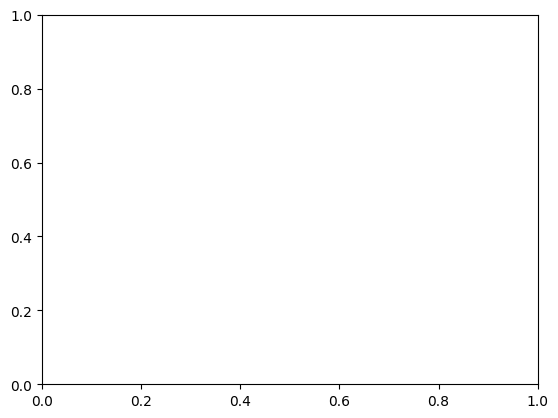

In [276]:
# # Create color maps
# cmap_light = ["orange", "cyan", "cornflowerblue"]
# cmap_bold = ["darkorange", "c", "darkblue"]

# for weights in ["uniform", "distance"]:
#     # we create an instance of Neighbours Classifier and fit the data.
#     clf = KNeighborsClassifier(n_neighbors=1)
#     clf.fit(X_train, y_train)

#     _, ax = plt.subplots()
#     DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X_train,
#         cmap=cmap_light,
#         ax=ax,
#         response_method="predict",
#         plot_method="pcolormesh",
#         shading="auto",
#     )

#     # Plot also the training points
#     sns.scatterplot(
#         x=X_train[:, 0],
#         y=X_train[:, 1],
#         palette=cmap_bold,
#         alpha=1.0,
#         edgecolor="black",
#     )

# plt.show()

### Logistic Regression

In [237]:
regr = Pipeline([
    ('tfidf',  TfidfTransformer(smooth_idf=True)),
    ('nb', linear_model.LogisticRegression(penalty='l2', class_weight='balanced')),])


model = regr.fit(X_train, y_train)
y_predict = model.predict(X_validate)

regr_prec, regr_recall = scorer(y_validate, y_predict)
regr_f1 = f1_score(y_validate, y_predict)
regr_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', regr_f1)
print('Accuracy_Score: ', regr_acc)
print('--'*20)

Number of mislabeled points out of a total 11007 points : 4102
Number of correctly labelled points out of a total 11007 points : 6905
Number of false positives out of a total 11007 points : 2414
Number of false negatives out of a total 11007 points : 1688
----------------------------------------
F1_Score:  0.6574816299265197
Accuracy_Score:  0.6273280639592986
----------------------------------------


### Decision Trees

In [251]:
dtree = tree.DecisionTreeClassifier(criterion='gini')


model = dtree.fit(X_train, y_train)
y_predict = model.predict(X_validate)

tree_prec, tree_recall = scorer(y_validate, y_predict)
tree_f1 = f1_score(y_validate, y_predict)
tree_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', tree_f1)
print('Accuracy_Score: ', tree_acc)
print('--'*20)

Number of mislabeled points out of a total 11007 points : 413
Number of correctly labelled points out of a total 11007 points : 10594
Number of false positives out of a total 11007 points : 407
Number of false negatives out of a total 11007 points : 6
----------------------------------------
F1_Score:  0.9645523989357137
Accuracy_Score:  0.9624784228218406
----------------------------------------


[Text(0.6124509017109229, 0.9880952380952381, 'x[6] <= 0.201\nlog_loss = 1.0\nsamples = 44027\nvalue = [22135, 21892]'),
 Text(0.32871619039152783, 0.9642857142857143, 'x[6] <= -0.058\nlog_loss = 0.987\nsamples = 31960\nvalue = [13878, 18082]'),
 Text(0.06959043161057187, 0.9404761904761905, 'x[1] <= 3.861\nlog_loss = 0.922\nsamples = 8557\nvalue = [2882, 5675]'),
 Text(0.00514077434669326, 0.9166666666666666, 'x[0] <= 14.5\nlog_loss = 0.829\nsamples = 329\nvalue = [243, 86]'),
 Text(0.003792374518052405, 0.8928571428571429, 'x[1] <= 3.789\nlog_loss = 0.337\nsamples = 80\nvalue = [75, 5]'),
 Text(0.003342907908505453, 0.8690476190476191, 'log_loss = 0.0\nsamples = 65\nvalue = [65, 0]'),
 Text(0.004241841127599357, 0.8690476190476191, 'x[0] <= 6.5\nlog_loss = 0.918\nsamples = 15\nvalue = [10, 5]'),
 Text(0.003792374518052405, 0.8452380952380952, 'log_loss = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.004691307737146308, 0.8452380952380952, 'log_loss = 0.0\nsamples = 10\nvalue = [10, 0]'

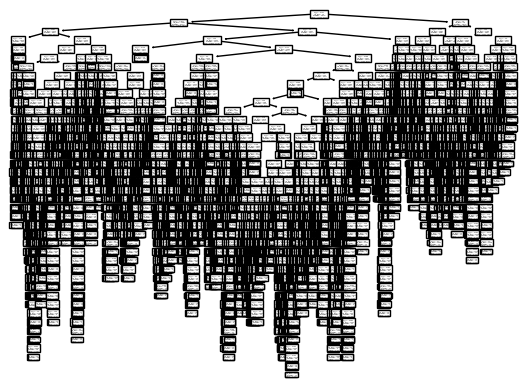

In [244]:
tree.plot_tree(dtree)

### Gaussian Naive Bayes

In [266]:
gnb = GaussianNB()

model = gnb.fit(X_train, y_train)
y_predict = model.predict(X_validate)

gnb_prec, gnb_recall = scorer(y_validate, y_predict)
gnb_f1 = f1_score(y_validate, y_predict)
gnb_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', gnb_f1)
print('Accuracy_Score: ', gnb_acc)
print('--'*20)

Number of mislabeled points out of a total 11007 points : 4204
Number of correctly labelled points out of a total 11007 points : 6803
Number of false positives out of a total 11007 points : 3036
Number of false negatives out of a total 11007 points : 1168
----------------------------------------
F1_Score:  0.6795243177313616
Accuracy_Score:  0.6180612337603343
----------------------------------------


### Stochastic Gradient Descent

In [221]:
sgd = Pipeline([
    ('tfidf',  TfidfTransformer(smooth_idf=True)), 
    ('nb', SGDClassifier(max_iter=1000, tol=1e-3)),])


model = sgd.fit(X_train, y_train)
y_predict = model.predict(X_validate)

sgd_prec, sgd_recall = scorer(y_validate, y_predict)
sgd_f1 = f1_score(y_validate, y_predict)
sgd_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', sgd_f1)
print('Accuracy_Score: ', sgd_acc)
print('--'*20)

Number of mislabeled points out of a total 11007 points : 4186
Number of correctly labelled points out of a total 11007 points : 6821
Number of false positives out of a total 11007 points : 2510
Number of false negatives out of a total 11007 points : 1676
----------------------------------------
F1_Score:  0.6535915259847732
Accuracy_Score:  0.6196965567366222
----------------------------------------


### XGB

In [222]:
pipeline_xgb = Pipeline([
    ('tfidf',  TfidfTransformer(smooth_idf=True)),
    ('nb', xgb.XGBClassifier()),])

model = pipeline_xgb.fit(X_train, y_train)
y_predict = model.predict(X_validate)

xgb_prec, xgb_recall = scorer(y_validate, y_predict)
xgb_f1 = f1_score(y_validate, y_predict)
xgb_acc = accuracy_score(y_validate, y_predict)

print('--'* 20)
print('F1_Score: ', xgb_f1)
print('Accuracy_Score: ', xgb_acc)
print('--'*20)

Number of mislabeled points out of a total 11007 points : 1613
Number of correctly labelled points out of a total 11007 points : 9394
Number of false positives out of a total 11007 points : 1279
Number of false negatives out of a total 11007 points : 334
----------------------------------------
F1_Score:  0.8677326773267734
Accuracy_Score:  0.8534568910693195
----------------------------------------


## Results

In [223]:
score_df = pd.DataFrame({'model' : ['knn', 'regr', 'tree', 'gnb', 'sgd', 'xgb'], 
'f1' : [knn_f1, regr_f1, tree_f1, gnb_f1, sgd_f1, xgb_f1], 
'acc' : [knn_acc, regr_acc, tree_acc, gnb_acc, sgd_acc, xgb_acc], 
'precision' : [knn_prec, regr_prec, tree_prec, gnb_prec, sgd_prec, xgb_prec],
'recall' : [knn_recall, regr_recall, tree_recall, gnb_recall, sgd_recall, xgb_recall]})

score_df.sort_values(by=['f1'], ascending=False)

,model,f1,acc,precision,recall
2,tree,0.960677,0.958208,0.925243,0.998933
0,knn,0.949608,0.946852,0.921123,0.979911
5,xgb,0.867733,0.853457,0.805327,0.940622
3,gnb,0.679524,0.618061,0.594822,0.792356
1,regr,0.657482,0.627328,0.619902,0.699911
4,sgd,0.653592,0.619697,0.611395,0.702044


<Axes: xlabel='model'>

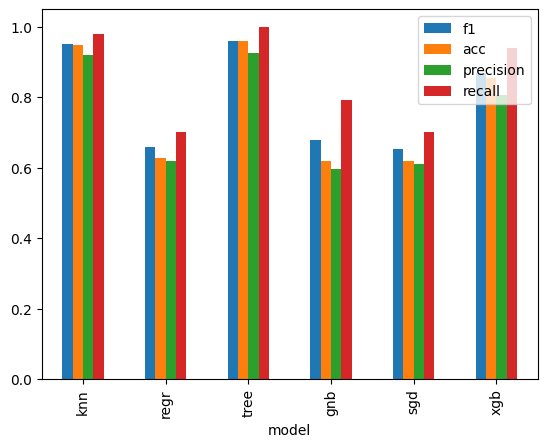

In [224]:
score_df.plot(kind='bar', x='model')